In [115]:

import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:

input_file = codecs.open("/content/drive/MyDrive/01- DOUTORADO/03- NLP/socialmedia_relevant_cols.csv", "r",encoding='utf-8', errors='replace')
output_file = open("socialmedia_relevant_cols_clean.csv", "w")

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

In [118]:
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv")
questions.columns=['text', 'choose_one', 'class_label']
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:

questions.tail()

,text,choose_one,class_label
10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,Relevant,1
10872,Police investigating after an e-bike collided ...,Relevant,1
10873,The Latest: More Homes Razed by Northern Calif...,Relevant,1
10874,MEG issues Hazardous Weather Outlook (HWO) htt...,Relevant,1
10875,#CityofCalgary has activated its Municipal Eme...,Relevant,1


In [121]:
questions.choose_one.unique()

array(['Relevant', 'Not Relevant', "Can't Decide"], dtype=object)

In [122]:
questions['choose_one'].value_counts()

Not Relevant    6187
Relevant        4673
Can't Decide      16
Name: choose_one, dtype: int64

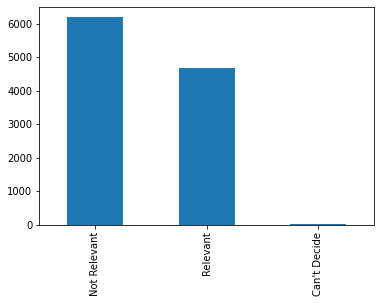

In [123]:
questions['choose_one'].value_counts().plot(kind='bar')

In [124]:

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [125]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10871,10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,1
10872,10872,police investigating after an e bike collided ...,Relevant,1
10873,10873,the latest more homes razed by northern calif...,Relevant,1
10874,10874,meg issues hazardous weather outlook (hwo),Relevant,1
10875,10875,cityofcalgary has activated its municipal eme...,Relevant,1


In [126]:

clean_questions.groupby("class_label").count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6187,6187,6187
1,4673,4673,4673
2,16,16,16


In [127]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [128]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

154724 words total, with a vocabulary size of 18101
Max sentence length is 34


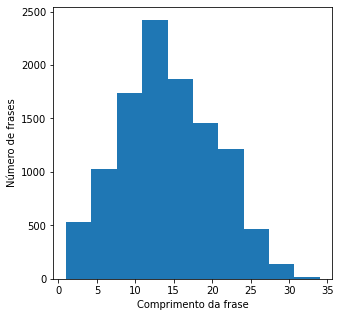

In [129]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5)) 
plt.xlabel('Comprimento da frase')
plt.ylabel('Número de frases')
plt.hist(sentence_lengths)
plt.show()

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

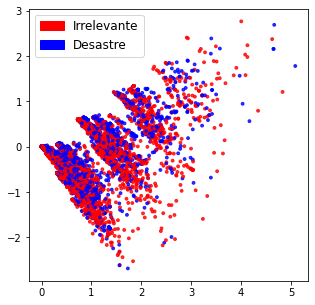

In [131]:

from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['red','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='red', label='Irrelevante')
            green_patch = mpatches.Patch(color='blue', label='Desastre')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 12})


fig = plt.figure(figsize=(5,5))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [132]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [133]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.754, precision = 0.752, recall = 0.754, f1 = 0.753


In [134]:

import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusão',
                          cmap=plt.cm.summer):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=12)
    
    plt.tight_layout()
    plt.ylabel('Rótulo verdadeiro', fontsize=12)
    plt.xlabel('Rótulo previsto', fontsize=12)

    return plt

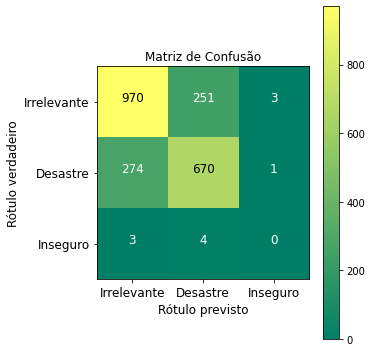

[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [135]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(5,5))
plot = plot_confusion_matrix(cm, classes=['Irrelevante','Desastre','Inseguro'], normalize=False, title='Matriz de Confusão')
plt.show()
print(cm)

In [136]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

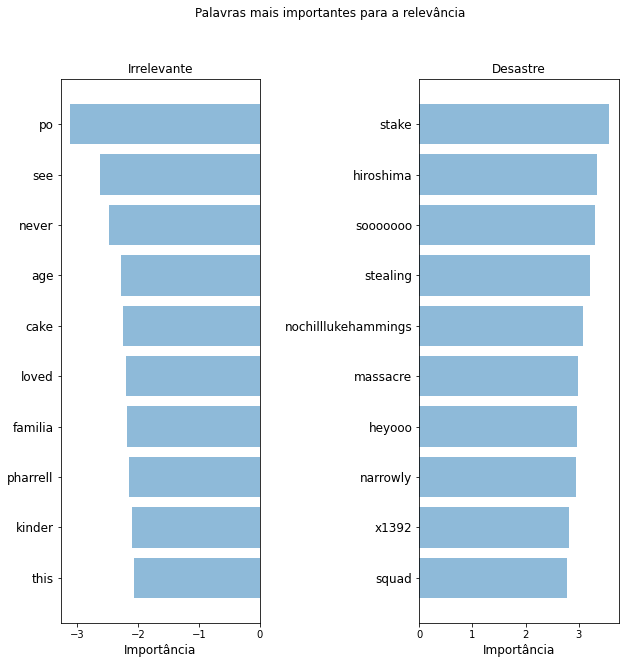

In [137]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10,10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevante', fontsize=12)
    plt.yticks(y_pos, bottom_words, fontsize=12)
    plt.suptitle('Key words', fontsize=12)
    plt.xlabel('Importância', fontsize=12)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Desastre', fontsize=12)
    plt.yticks(y_pos, top_words, fontsize=12)
    plt.suptitle(name, fontsize=12)
    plt.xlabel('Importância', fontsize=12)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Palavras mais importantes para a relevância")

In [138]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

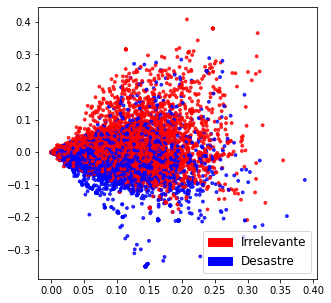

In [139]:
fig = plt.figure(figsize=(5,5))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [140]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [141]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.762, precision = 0.760, recall = 0.762, f1 = 0.761


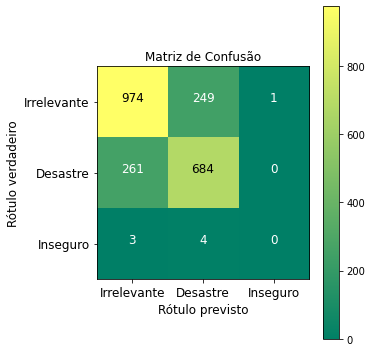

TFIDF confusion matrix
[[974 249   1]
 [261 684   0]
 [  3   4   0]]
BoW confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [142]:

import matplotlib.pyplot as plt

cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(5,5))
plot = plot_confusion_matrix(cm2, classes=['Irrelevante','Desastre','Inseguro'], normalize=False, title='Matriz de Confusão')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [143]:

importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

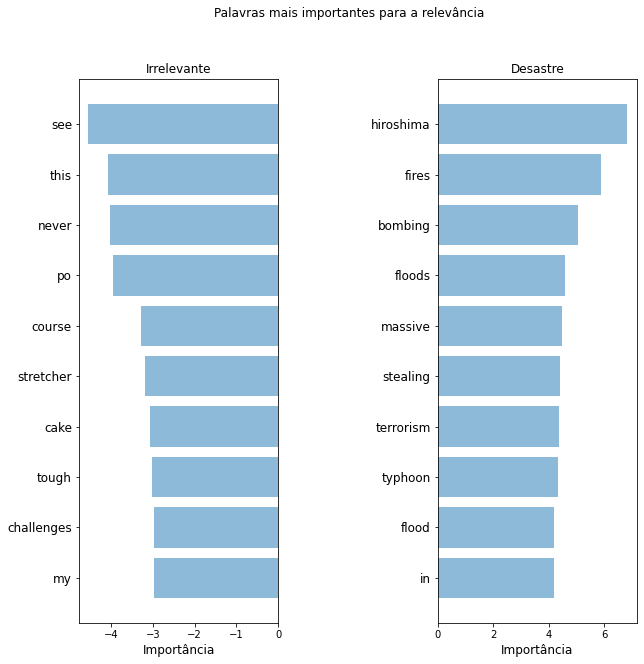

In [144]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Palavras mais importantes para a relevância")

## https://www.kaggle.com/jannesklaas/nlp-disasters/

# Lemmatization

In [145]:
import spacy

In [146]:
nlp = spacy.load('en',disable=['tagger','parser','ner'])

In [147]:
from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)

In [148]:
questions['lemmas'] = questions["text"].progress_apply(lambda row: 
                                         [w.lemma_ for w in nlp(row)])

100%|██████████| 10876/10876 [00:02<00:00, 4485.42it/s]


In [149]:
questions.head()

,text,choose_one,class_label,lemmas
0,just happened a terrible car crash,Relevant,1,"[just, happen, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deed, be, the, reason, of, this, , eart..."
2,"heard about earthquake is different cities, s...",Relevant,1,"[hear, about, , earthquake, be, different, ci..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, be, a, forest, fire, at, spot, pond, ,..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, , canada]"


In [150]:
questions['joint_lemmas'] = questions['lemmas'].progress_apply(lambda row: ' '.join(row))

100%|██████████| 10876/10876 [00:00<00:00, 413975.94it/s]


In [151]:
questions.head()

,text,choose_one,class_label,lemmas,joint_lemmas
0,just happened a terrible car crash,Relevant,1,"[just, happen, a, terrible, car, crash]",just happen a terrible car crash
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deed, be, the, reason, of, this, , eart...",our deed be the reason of this earthquake ma...
2,"heard about earthquake is different cities, s...",Relevant,1,"[hear, about, , earthquake, be, different, ci...","hear about earthquake be different city , st..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, be, a, forest, fire, at, spot, pond, ,...","there be a forest fire at spot pond , goose be..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, , canada]",forest fire near la ronge sask canada


## Bag of words

In [152]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(questions['joint_lemmas'], 
                                                    questions['class_label'], 
                                                    test_size=0.2,
                                                    random_state=40)

In [153]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_features=5000)
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [154]:
X_train_counts.shape

(8700, 5000)

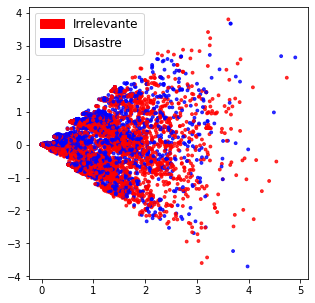

In [155]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
 

lsa = TruncatedSVD(n_components=2)
lsa.fit(X_train_counts)
lsa_scores = lsa.transform(X_train_counts)


fig = plt.figure(figsize=(5,5))   
colors = ['Red','blue']

plt.scatter(lsa_scores[:,0], 
            lsa_scores[:,1], 
            s=8, alpha=.8, 
            c=y_train,
            cmap=matplotlib.colors.ListedColormap(colors))

ir_patch = mpatches.Patch(color='Red',label='Irrelevante')

dis_patch = mpatches.Patch(color='Blue',label='Disastre')

plt.legend(handles=[ir_patch, dis_patch], prop={'size': 12})

plt.show()

In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression()

clf.fit(X_train_counts, y_train)

y_predicted = clf.predict(X_test_counts)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [157]:
accuracy_1, precision_1, recall_1, f1_1 = get_metrics(y_test, y_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_1, precision_1, 
                                                                       recall_1, f1_1))

accuracy = 0.776, precision = 0.773, recall = 0.776, f1 = 0.773


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [158]:
accuracy_score(y_test, y_predicted)

0.7757352941176471

In [159]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.summer):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=12)
    
    plt.tight_layout()
    plt.ylabel('Rótulo verdadeiro', fontsize=12)
    plt.xlabel('Rótulo previsto', fontsize=12)
    return plt

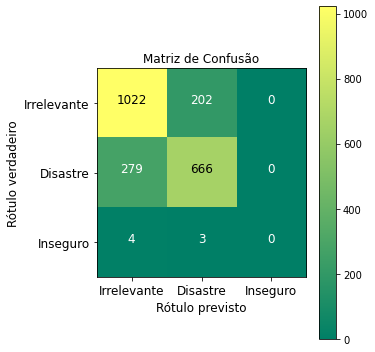

[[1022  202    0]
 [ 279  666    0]
 [   4    3    0]]


In [160]:
cm = confusion_matrix(y_test, y_predicted)
fig = plt.figure(figsize=(5,5))
plot = plot_confusion_matrix(cm, classes=['Irrelevante','Disastre','Inseguro'], normalize=False, title='Matriz de Confusão')
plt.show()
print(cm)

In [161]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

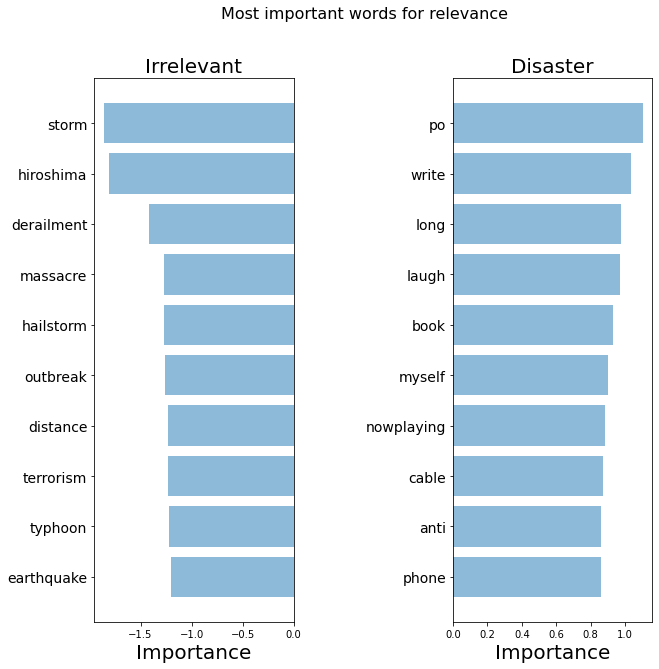

In [162]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

## Word vectors

In [163]:
from keras.preprocessing.text import Tokenizer
import numpy as np

max_words = 10000 # We will only consider the 10K most used words in this dataset

In [164]:
tokenizer = Tokenizer(num_words=max_words) # Setup
tokenizer.fit_on_texts(questions['joint_lemmas']) # Generate tokens by counting frequency
sequences = tokenizer.texts_to_sequences(questions['joint_lemmas']) # Turn text into sequence of numbers

In [165]:
word_index = tokenizer.word_index
print('Token for "the"',word_index['the'])
print('Token for "Movie"',word_index['movie'])

Token for "the" 1
Token for "Movie" 337


In [166]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 140 # Make all sequences 140 words long
data = pad_sequences(sequences, maxlen=maxlen)
print(data.shape) # We have 25K, 140 word sequences now

(10876, 140)


In [183]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    questions['class_label'],
                                                    
                                                    test_size = 0.2, 
                                                    shuffle=True, 
                                                    random_state = 42)

Training custom word vectors

In [184]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

embedding_dim = 50

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 140, 50)           500000    
_________________________________________________________________
flatten_5 (Flatten)          (None, 7000)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                224032    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 724,065
Trainable params: 724,065
Non-trainable params: 0
_________________________________________________________________


In [185]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [186]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

y_predicted = model.predict(X_test)

Epoch 1/10
272/272 [==============================] - 4s 12ms/step - loss: 0.6578 - acc: 0.6071 - val_loss: 0.4498 - val_acc: 0.8038
Epoch 2/10
272/272 [==============================] - 3s 12ms/step - loss: 0.3706 - acc: 0.8442 - val_loss: 0.4333 - val_acc: 0.8088
Epoch 3/10
272/272 [==============================] - 3s 11ms/step - loss: 0.2303 - acc: 0.9116 - val_loss: 0.4857 - val_acc: 0.7835
Epoch 4/10
272/272 [==============================] - 3s 12ms/step - loss: 0.1301 - acc: 0.9538 - val_loss: 0.5403 - val_acc: 0.7891
Epoch 5/10
272/272 [==============================] - 3s 11ms/step - loss: 0.0805 - acc: 0.9696 - val_loss: 0.6140 - val_acc: 0.7904
Epoch 6/10
272/272 [==============================] - 3s 11ms/step - loss: 0.0563 - acc: 0.9721 - val_loss: 0.6684 - val_acc: 0.7528
Epoch 7/10
272/272 [==============================] - 3s 11ms/step - loss: 0.0591 - acc: 0.9733 - val_loss: 0.6632 - val_acc: 0.7826
Epoch 8/10
272/272 [==============================] - 3s 11ms/step - 

In [187]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from sklearn.metrics import f1_score
y_predicted_nn = model.predict_classes(X_test)
accuracy_score(y_pred=y_predicted_nn, y_true=y_test)


#f1_score(y_pred=y_predicted_nn, y_true=y_test, average='weighted')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.7881433823529411

In [188]:
accuracy_1, precision_1, recall_1, f1_1 = get_metrics(y_test, y_predicted_nn)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_1, precision_1, 
                                                                       recall_1, f1_1))

accuracy = 0.788, precision = 0.787, recall = 0.788, f1 = 0.786


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [189]:
from sklearn.metrics import classification_report
#target_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
preds = model.predict(X_test)
print(classification_report(y_test, y_predicted_nn))#, target_names=target_names))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1216
           1       0.79      0.70      0.75       957
           2       0.00      0.00      0.00         3

    accuracy                           0.79      2176
   macro avg       0.53      0.52      0.52      2176
weighted avg       0.79      0.79      0.79      2176



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


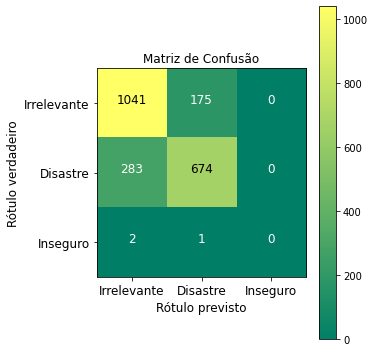

In [190]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_predicted_nn)#, labels=CATEGORIES)
confusion_matrix


fig = plt.figure(figsize=(5,5))
plot = plot_confusion_matrix(confusion_matrix, classes=['Irrelevante','Disastre','Inseguro'], normalize=False, title='Matriz de Confusão')
plt.show()
